<table width="100%">
    <td align="left">
        <a target="_blank", href="https://www.up.pt/fcup/en/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2023/03/FCUP_logo-print_blcktransp_600ppi.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td>
        <a target="_blank", href="https://www.iastro.pt/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2018/03/IA_logo_bitmap-rgbblack-1200px-388x259.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td align="center">
        <a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Distribution%20illustrations.ipynb">
           <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab
        </a>
    </td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-04-Distribution%20illustrations.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
#%matplotlib inline

In [2]:
# I like bigger plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# Comparing multiple distributions

This simple notebook is created to compare ways to display distributions. Here in particular I want to show how to compare multiple distributions.

In [3]:
centre1 = [1.0, 1.3, 2.8, 1.8, 4.5, 7.6]
scale1 = [0.6, 0.3, 0.7, 1.5, 1.2, 0.7]
centre2 = [None, None, 0.5, 3.2, None, 2.5]
scale2 = [1.0, 1.0, 0.7, 0.6, 1.0, 0.9]
norm = [1.0, 1.0, 0.8, 1.7, 1.0, 1.0]

N_ref= 100

In [4]:
d = dict()

# I also want to count the total number of data points
n_total_data = 0
for i in range(len(centre1)):
    x_r1 = np.random.normal(centre1[i], scale1[i], size=N_ref)
    if centre2[i] is None:
        pass
    else:
        x_r2 = np.random.normal(centre2[i], scale2[i], size=int(N_ref*norm[i]))
        x_r1 = np.append(x_r1, x_r2)
        
    d[i] = x_r1
    n_total_data += len(x_r1)

## Showing the data fully

This plots points in vertical strips. There are various ways to do this. I will first use a simple approach using matplotlib and then show a more complex, but powerful way to convert the data into a form useful for Seaborn.

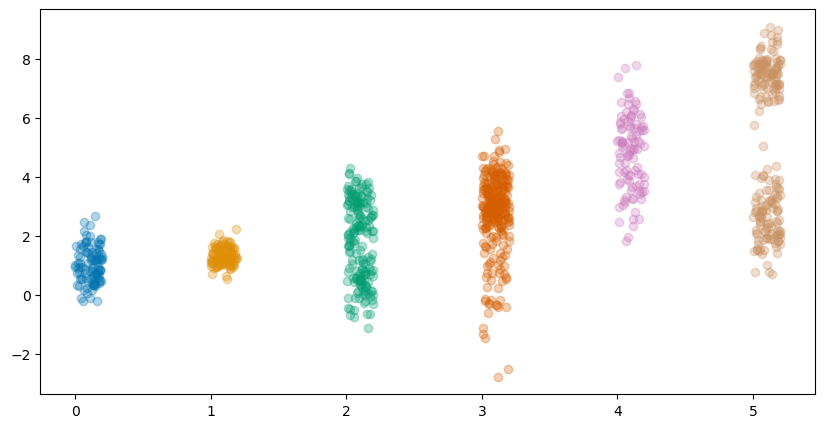

In [5]:
fig, ax = plt.subplots(ncols=1)

# I need to know the number of columns to show
n_columns = len(d.keys())
# Allow some jitter to show the data better.
jitter = 0.2

for i in range(n_columns):
    y = d[i]
    x = i+np.random.uniform(size=len(y))*jitter
    ax.scatter(x, y, alpha=0.3)


To show this using `stripplot` in seaborn we need to massage the data a bit. We need now to have one vector with all data and another with the id of each. 

In [6]:
data_vector = np.zeros(n_total_data)
label_vector = np.zeros(n_total_data, int) # This could instead be a string array for instance.

In [7]:
i_start = 0
for i in range(n_columns):
    y = d[i]
    i_end = i_start + len(y)
    data_vector[i_start:i_end] = y
    label_vector[i_start:i_end] = i
    i_start = i_end

In [8]:
ds = {'y': data_vector, 'x': label_vector}

<Axes: xlabel='x', ylabel='y'>

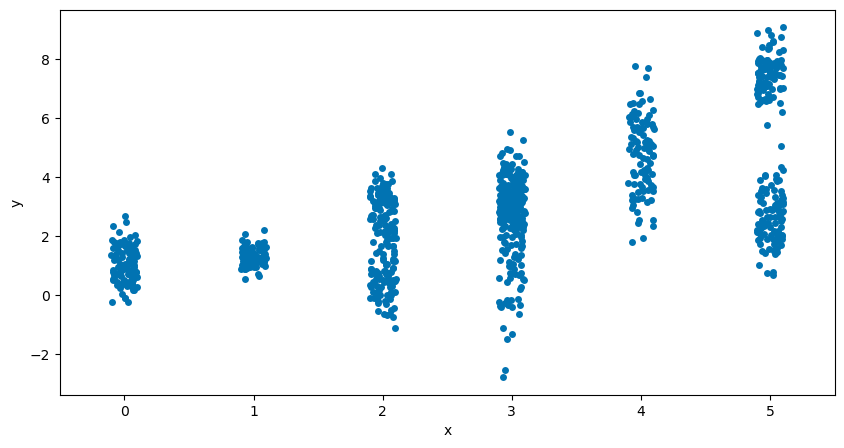

In [9]:
sns.stripplot(x='x', y='y', data=ds)

## Silly histograms

Next, try to compare these by overplotting histograms.

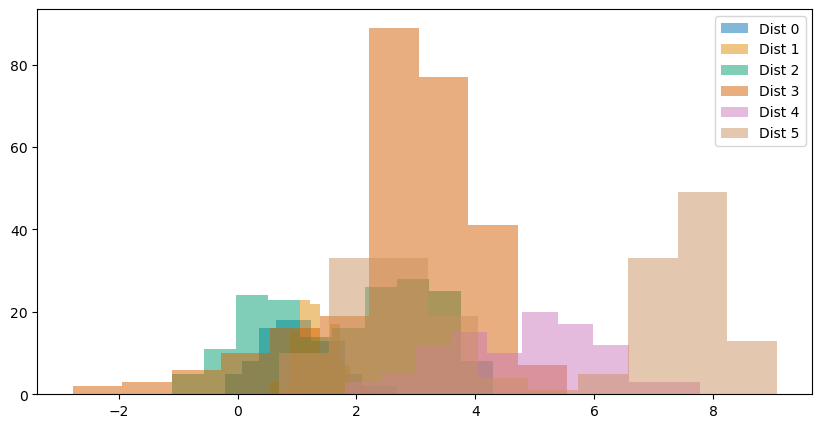

In [10]:
for i in range(len(d.keys())):
    plt.hist(d[i], label="Dist {0}".format(i), alpha=0.5)

plt.legend()

## Layered histograms

We could imagine making multiple histograms that are one above the other.

In [11]:
def plothist(x, bins='auto', yoffset=0, color=None, norm=False, peak=None,
             fill=False, ax=None, **kwargs):
    """Convenience function for manually plotting a histogram
    
    This allows for a flexible baselevel
    """
    
    if ax is None:
        fig, ax = plt.subplots()
    
    yhist, xbins = np.histogram(x, bins=bins, density=norm)
    if peak is not None:
        yhist = peak*yhist/np.max(yhist)

    # But to get the edges of the histogram in the plot,
    # we need to pad these a bit.
    xhist = np.hstack([xbins[0], xbins, xbins[-1]])
    yhist = np.hstack([0, yhist[0], yhist, 0])
    
    try:
        col = kwargs['c']
    except:
        col = None
    
    # Finally, to make a histogram plot we use step and fill_between
    plt.step(xhist, yhist+yoffset, where='pre', **kwargs)
    if fill:
        plt.fill_between(xhist, yhist+yoffset, yoffset, step='pre', color=col)

    return ax




[]

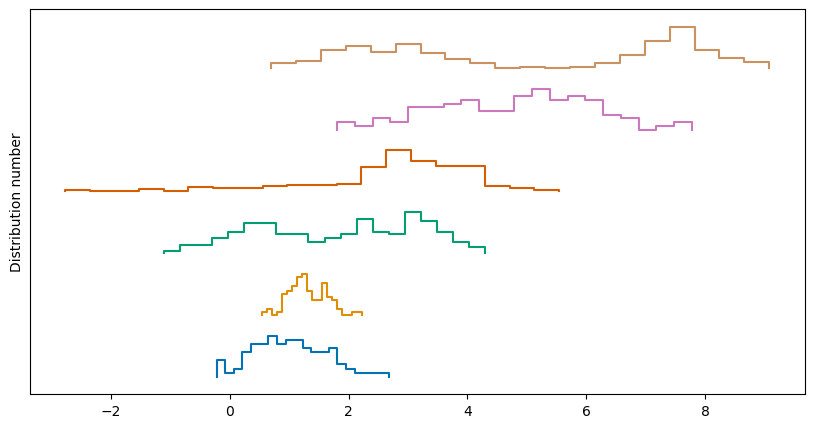

In [12]:
fig, ax = plt.subplots()

y_start = 0
dy = 1.5
for i in range(n_columns):
    plothist(d[i], yoffset=y_start+dy*i, fill=False, ax=ax, peak=1, bins=20)
    
ax.set_ylabel('Distribution number')
ax.set_yticks([])

That is not bad and might often be a good option but it does not summarise things very well.

## Better options - error bars and box plots

We can summarise things in simple ways - that gives us error bars, and the next step is box plots.

/tmp/ipykernel_53951/429587438.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(xplot, means, stdevs, fmt='o', marker='o', capsize=3)


<ErrorbarContainer object of 3 artists>

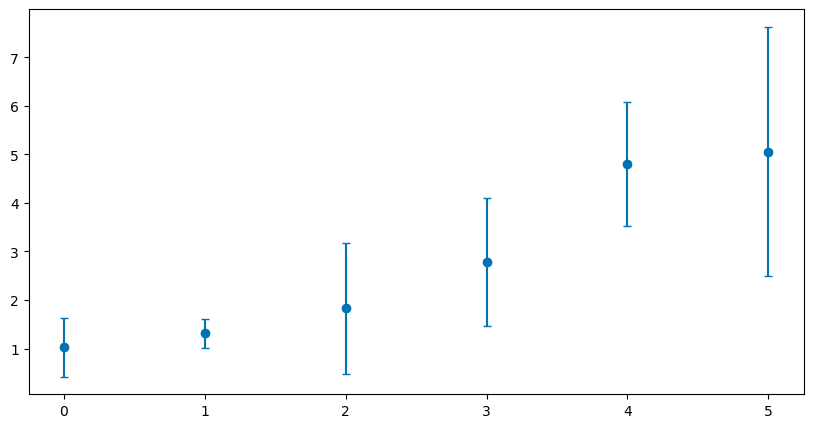

In [13]:
stdevs = np.zeros(n_columns)
means = np.zeros_like(stdevs)
for i in range(n_columns):
    stdevs[i] = np.std(d[i])
    means[i] = np.mean(d[i])

xplot = np.arange(n_columns)
plt.errorbar(xplot, means, stdevs, fmt='o', marker='o', capsize=3)

But that throws away a lot of information and makes it seem as if the errors are symmetric. We can of course improve on this, but let us instead move to box plots.

In [14]:
l = [d[i] for i in range(n_columns)]

<Axes: >

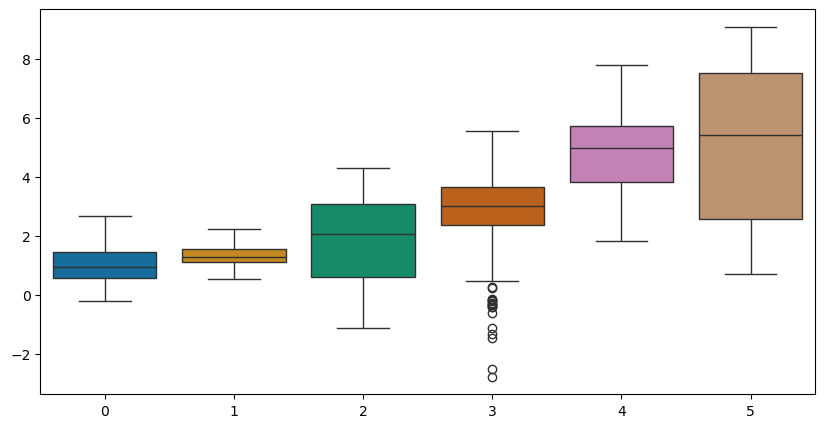

In [15]:
sns.boxplot(data=l)

<Axes: >

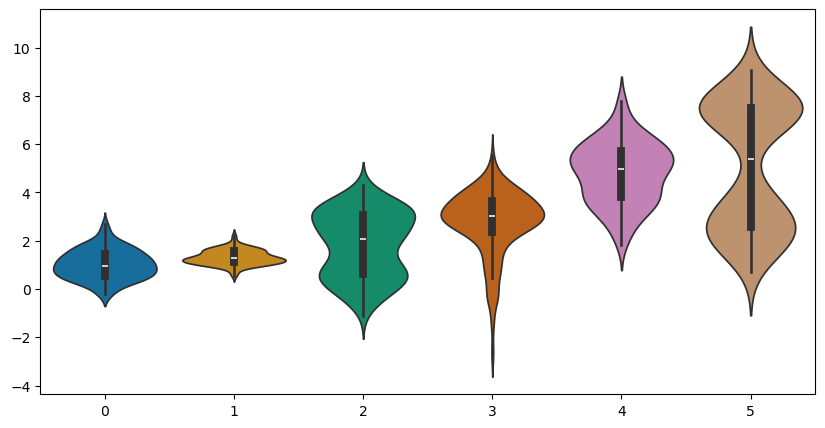

In [16]:
sns.violinplot(data=l, density_norm='width')

# Trying out 

A set of 13 datasets. The command to download the file in Colab is below - if you are running off your own machine, just copy or link the file into the directory with the notebook.

Calculate summary statistics (mean, standard deviation, correlation coefficient, maybe a linear fit) for each dataset - what do you conclude?

In [19]:
!wget --quiet -O several_datasets.tsv https://github.com/jbrinchmann/MLD2025/blob/main/Datafiles/several_datasets.csv

Astropy's table package might be a good way to read it in:

In [23]:
from astropy.table import Table
t = Table().read("several_datasets.tsv", format="ascii.fast_tab")

In [26]:
import pandas as pd
table=pd.read_csv("several_datasets.tsv",delimiter="\t")

In [25]:
t

x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
32.3311102266,61.411101248,51.2038911373,83.3397766053,55.9930301513,79.2772636977,55.3846,97.1795,51.1479167122,90.8674123313,53.366566866,90.2080300059,57.6132335477,83.9051707998,52.8720214902,97.3432226575,47.6952008891,95.2411869282,58.2136082599,91.881891513,50.4815081703,93.2227013657,65.8155400946,95.5883740582,38.3377571839,92.472719051
53.4214628807,26.1868803879,58.9744699018,85.499817612,50.0322537946,79.013071199,51.5385,96.0256,50.5171258092,89.1023945866,52.8019793617,90.0880645063,51.2743918205,82.8179829379,59.0141444945,93.5748748733,44.6099759113,93.075835032,58.1960536923,92.2149886482,50.2824056687,97.6099835723,65.6722651618,91.9334018119,35.7518707905,94.1167680276
63.92020226,30.8321939163,51.8720726696,85.8297376348,51.2884586593,82.4359398425,46.1538,94.4872,50.2074801993,85.4600473951,47.0541298828,90.458936026,50.7538984114,76.7541289533,56.3751090389,96.30514763,43.8563814822,94.0858717713,58.7182307185,90.310532087,50.1867033389,99.6946801425,39.002716451,92.26183816,32.7672179591,88.5182945794
70.2895057187,82.5336485877,48.1799307865,85.0451167372,51.1705368873,79.1652941091,42.8205,91.4103,50.0694819181,83.0576695262,42.4484337816,89.5077001153,37.0211840116,81.954469997,37.8391996844,94.359443503,41.5789293984,90.3035665387,57.27837287,89.9076067166,50.3269108629,90.0220534916,37.7953028026,93.5324553607,33.7296067755,88.622265789
34.1188302357,45.7345513203,41.6832004024,84.0179406019,44.3779145287,78.1646280036,40.7692,88.3333,50.5628463386,82.9378217764,42.7040363241,90.4426288607,42.8817550897,80.1847700514,39.8853734176,90.6346620817,49.1774185559,96.6105324538,58.082020494,92.0081450101,50.4562073315,89.9874101286,35.5139005857,89.5991901138,37.238249327,83.7249284144
67.6707164012,37.110947969,37.8904155015,82.5674929978,45.0102700721,77.8808631153,38.7179,84.8718,50.288527801,82.9752535659,32.3789386326,90.144142631,37.1557104777,84.9541114129,44.0774051326,84.1258533023,42.6522509813,90.5606397307,57.4894477748,88.0852855629,30.4648469308,82.0892320845,39.2194529062,83.5434818364,36.0271982243,82.0407806505
53.2591294055,97.4757710964,39.5489736947,80.812601774,48.559816719,78.7883706035,35.641,79.8718,25.5834750822,82.9148911324,32.5307027362,70.1573965085,38.7318581261,83.7893564281,31.4970254888,67.9125621568,30.1233318217,81.1442953304,28.088741319,63.5107944263,30.5015964737,82.3071263462,31.5882013862,77.0280524208,39.2392807768,79.2637238398
63.5149808671,25.1000785788,39.6495738769,82.6645338713,42.1422682922,76.8806345544,33.0769,77.5641,25.4835833896,82.929084979,33.3652644305,70.4593354392,31.0005254108,82.5794805962,25.9525965456,73.0331803541,31.915519986,79.7904134869,28.0854682136,63.5901969481,30.489569227,77.7298801366,32.6577782482,80.1138612983,39.7845249391,82.2605658962
67.9805388133,80.9571652197,34.7505970472,80.0110909897,41.0269715735,76.4095884613,28.9744,74.4872,25.4435257049,82.8742004973,32.6560991775,70.0510704992,25.9854996226,74.3493875478,36.4347239148,62.2940454639,27.8877193574,75.4455759934,28.087273053,63.1232828116,30.45024833,79.8348944011,31.6415992679,77.6108331874,35.1660293896,84.1564919839


In [31]:
names_x=[]
names_y=[]

for i in range(1,14):
    names_x.append("x"+str(i))
    names_y.append("y"+str(i))

### Calcular a media, desvio padrao e coeficente de correlação
Mean=[]

for j in range(13):
    Mean.append(np.mean())

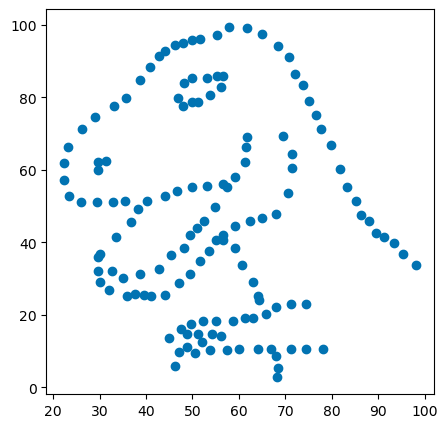

In [37]:
#### plot de tudo
plt.figure(figsize=(5,5))
for j in range(3,4):
    plt.scatter(table[names_x[j]],table[names_y[j]])

SyntaxError: incomplete input (3114588446.py, line 31)

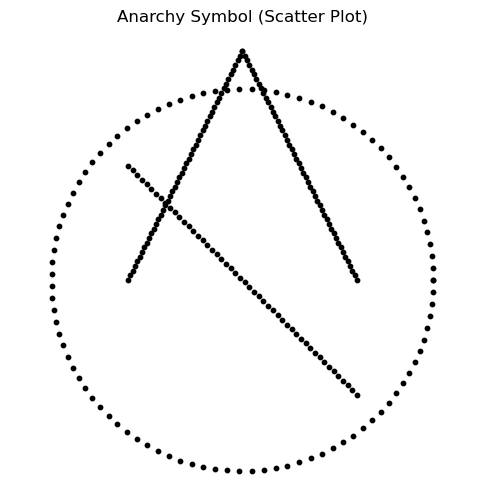

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
circle_radius = 1  # Radius of the enclosing circle
num_circle_points = 100  # Points on the circle
num_line_points = 50  # Points on each line

# Circle points
theta = np.linspace(0, 2 * np.pi, num_circle_points)
circle_x = circle_radius * np.cos(theta)
circle_y = circle_radius * np.sin(theta)

# "A" diagonal line
line1_x = np.linspace(-circle_radius * 0.6, circle_radius * 0.6, num_line_points)
line1_y = -line1_x  # Mirror diagonal for the A

# "A" vertical triangle lines
line2_x = np.linspace(-circle_radius * 0.6, 0, num_line_points)
line2_y = (line2_x + circle_radius * 0.6) * 2

line3_x = np.linspace(0, circle_radius * 0.6, num_line_points)
line3_y = (line3_x - circle_radius * 0.6) * -2

# Combine points
x_data = np.concatenate([circle_x, line1_x, line2_x, line3_x])
y_data = np.concatenate([circle_y, line1_y, line2_y, line3_y])

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=10, c="black")
plt.axis("equal")
plt.title("Anarchy Symbol (Scatter Plot)")
plt.axis("off")
plt.show()
